In [6]:
# === IMPORTS AND DATA SETUP ===
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from loaders import MnistLoader, SquareImageSplitingLoader

print("📚 Loading MNIST dataset...")
mnist_loader = MnistLoader()
train_loader, val_loader = mnist_loader.get_loaders()

# Create patch loaders for both training and validation
train_patch_loader = SquareImageSplitingLoader(train_loader)
val_patch_loader = SquareImageSplitingLoader(val_loader)

print("✅ Data ready!")

📚 Loading MNIST dataset...
mnist dataset loaded, train data size: 50000 validation data size: 10000
✅ Data ready!


In [7]:
# === VISION TRANSFORMER MODEL ===
    

class VisionTransformerEncoder(nn.Module):
    def __init__(self, patch_dim=49, embed_dim=32, num_patches=16, num_classes=10, num_heads=4):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        assert embed_dim % num_heads == 0, f"embed_dim ({embed_dim}) must be divisible by num_heads ({num_heads})"
        
        # Core components
        self.patch_embedding = nn.Linear(patch_dim, embed_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))
        
        # Multi-head self-attention
        self.W_q = nn.Linear(embed_dim, embed_dim)
        self.W_k = nn.Linear(embed_dim, embed_dim)
        self.W_v = nn.Linear(embed_dim, embed_dim)
        self.W_o = nn.Linear(embed_dim, embed_dim)  # Output projection
        
        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            nn.ReLU(),
            nn.Linear(embed_dim * 2, embed_dim)
        )
        
        # Layer normalization and classifier
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.classifier = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        # Flatten patches and embed: [batch, 16, 7, 7] -> [batch, 16, 49] -> [batch, 16, 32]
        x = x.flatten(start_dim=2)
        x = self.patch_embedding(x)
        x = x + self.pos_embedding
        
        # Multi-head self-attention block
        residual = x
        x = self.norm1(x)
        
        # Compute Q, K, V and reshape for multi-head attention
        batch_size, seq_len = x.shape[0], x.shape[1]
        
        Q = self.W_q(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Scaled dot-product attention for each head
        attention_scores = Q @ K.transpose(-2, -1) / (self.head_dim ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_output = attention_weights @ V
        
        # Concatenate heads and apply output projection
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.embed_dim)
        x = self.W_o(attention_output)
        x = residual + x  # Residual connection
        
        # Feed-forward block
        residual = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = residual + x  # Residual connection
        
        # Classification: average pool + classify
        x = x.mean(dim=1)
        return self.classifier(x)

# Create and test model
print("🤖 Creating Vision Transformer...")
model = VisionTransformerEncoder()

# Quick test
sample_batch = next(iter(train_patch_loader))
patches, labels = sample_batch
logits = model(patches)

print(f"✅ Model ready! Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"📊 Input: {patches.shape} -> Output: {logits.shape}")


🤖 Creating Vision Transformer...
✅ Model ready! Parameters: 10,986
📊 Input: torch.Size([128, 16, 1, 7, 7]) -> Output: torch.Size([128, 10])


In [ ]:
# === TRAINING FUNCTION ===
def train_model(model, train_loader, val_loader, epochs=15, lr=0.0001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Tracking lists
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    
    print(f"🚀 Training for {epochs} epochs...\n")
    
    for epoch in range(epochs):
        # === TRAINING ===
        model.train()
        total_loss, correct, total = 0, 0, 0
        num_batches = 0  # Count batches for safer averaging
        
        for batch_idx, (patches, labels) in enumerate(train_loader):
            # Forward pass
            logits = model(patches)
            loss = criterion(logits, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Statistics
            total_loss += loss.item()
            predicted = logits.argmax(dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            num_batches += 1
            
            # Progress update
            if batch_idx % 100 == 0:
                acc = 100 * correct / total
                print(f"   Batch {batch_idx:3d}: Loss = {loss:.4f}, Acc = {acc:.1f}%")
        
        # Epoch training stats - use batch count for reliable averaging
        avg_train_loss = total_loss / num_batches
        train_acc = 100 * correct / total
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)
        
        # === VALIDATION ===
        model.eval()
        total_loss, correct, total = 0, 0, 0
        num_batches = 0
        
        with torch.no_grad():
            for patches, labels in val_loader:
                logits = model(patches)
                loss = criterion(logits, labels)
                
                total_loss += loss.item()
                predicted = logits.argmax(dim=1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                num_batches += 1
        
        # Epoch validation stats - use batch count for reliable averaging
        avg_val_loss = total_loss / num_batches
        val_acc = 100 * correct / total
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)
        
        # Print epoch summary
        print(f"Epoch {epoch+1:2d}: Train Loss={avg_train_loss:.4f} Acc={train_acc:.1f}% | "
              f"Val Loss={avg_val_loss:.4f} Acc={val_acc:.1f}%\n")
        
        # Early stopping
        if val_acc > 95:
            print("🎉 Excellent accuracy reached! Stopping early.")
            break
    
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accs,
        'val_losses': val_losses,
        'val_accuracies': val_accs
    }

# Train the model
history = train_model(model, train_patch_loader, val_patch_loader, epochs=100, lr=0.0001)
print(f"✅ Training completed! Final accuracy: {history['val_accuracies'][-1]:.1f}%")

🚀 Training for 100 epochs...

   Batch   0: Loss = 2.2503, Acc = 18.8%
   Batch 100: Loss = 2.2815, Acc = 11.9%
   Batch 200: Loss = 2.2841, Acc = 13.2%
   Batch 300: Loss = 2.2593, Acc = 16.1%
Epoch  1: Train Loss=2.2812 Acc=18.7% | Val Loss=2.2377 Acc=33.6%

   Batch   0: Loss = 2.2352, Acc = 37.5%
   Batch 100: Loss = 2.1661, Acc = 32.0%
   Batch 200: Loss = 2.0203, Acc = 34.7%
   Batch 300: Loss = 1.6756, Acc = 38.6%
Epoch  2: Train Loss=1.9677 Acc=42.1% | Val Loss=1.4543 Acc=56.7%

   Batch   0: Loss = 1.4655, Acc = 55.5%
   Batch 100: Loss = 1.2604, Acc = 58.6%
   Batch 200: Loss = 1.1063, Acc = 61.2%
   Batch 300: Loss = 0.8753, Acc = 63.5%
Epoch  3: Train Loss=1.1093 Acc=65.2% | Val Loss=0.8645 Acc=72.2%

   Batch   0: Loss = 0.8936, Acc = 76.6%
   Batch 100: Loss = 0.8128, Acc = 74.5%
   Batch 200: Loss = 0.6154, Acc = 75.5%
   Batch 300: Loss = 0.6886, Acc = 76.2%
Epoch  4: Train Loss=0.7341 Acc=76.8% | Val Loss=0.6613 Acc=78.6%

   Batch   0: Loss = 0.5580, Acc = 84.4%
   Ba

/var/folders/r9/skgbrp6j3n38_nkzfz68r4t00000gn/T/ipykernel_23441/1044679625.py:39: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/r9/skgbrp6j3n38_nkzfz68r4t00000gn/T/ipykernel_23441/1044679625.py:39: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/r9/skgbrp6j3n38_nkzfz68r4t00000gn/T/ipykernel_23441/1044679625.py:39: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/r9/skgbrp6j3n38_nkzfz68r4t00000gn/T/ipykernel_23441/1044679625.py:39: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/r9/skgbrp6j3n38_nkzfz68r4t00000gn/T/ipykernel_23441/1044679625.py:39: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


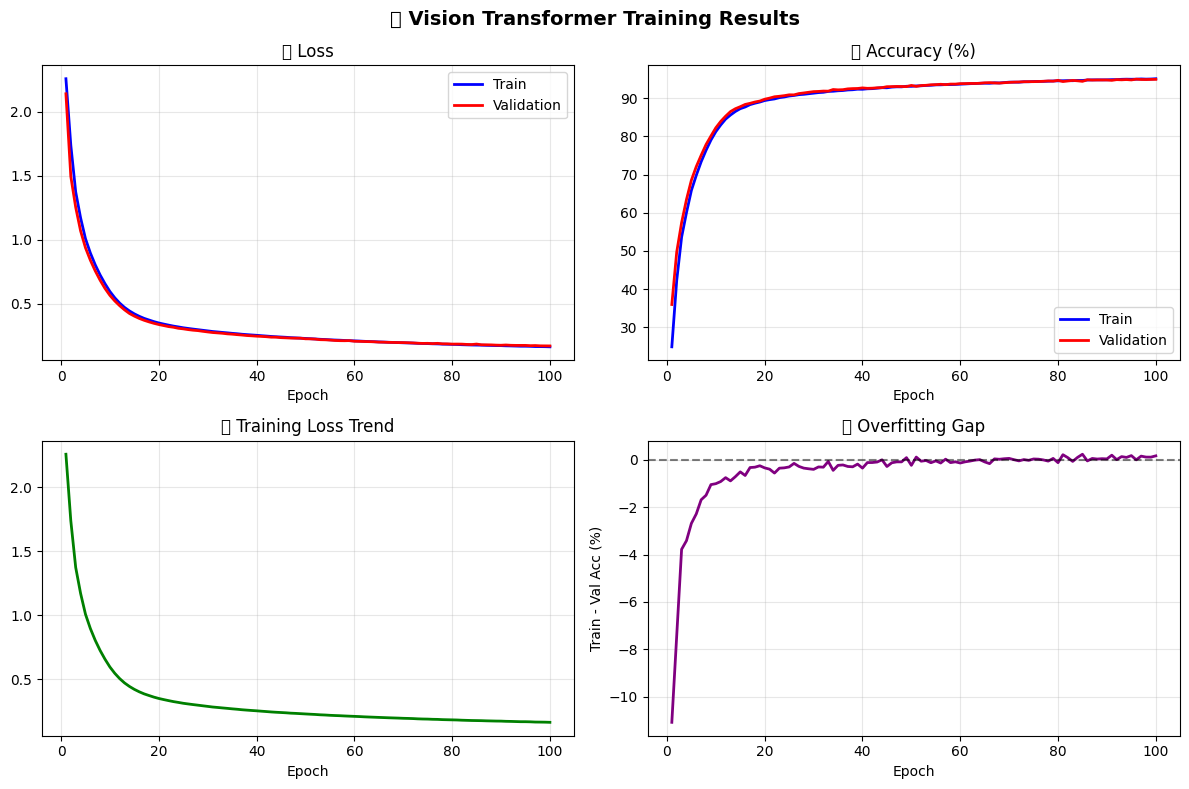

📊 FINAL RESULTS:
   Training Loss: 0.1624
   Validation Loss: 0.1693
   Training Accuracy: 95.08%
   Validation Accuracy: 94.92%
   Best Validation: 94.97%

🎯 PREDICTION ANALYSIS:
✅ Correct predictions:
   1. Actual: 8, Predicted: 8
   2. Actual: 2, Predicted: 2
   3. Actual: 5, Predicted: 5
❌ Wrong predictions:
   1. Actual: 5, Predicted: 3
   2. Actual: 9, Predicted: 7
   3. Actual: 7, Predicted: 2


In [5]:
# === VISUALIZATION AND ANALYSIS ===
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('🎯 Vision Transformer Training Results', fontsize=14, fontweight='bold')
    
    epochs = range(1, len(history['train_losses']) + 1)
    
    # Loss curves
    axes[0, 0].plot(epochs, history['train_losses'], 'b-', label='Train', linewidth=2)
    axes[0, 0].plot(epochs, history['val_losses'], 'r-', label='Validation', linewidth=2)
    axes[0, 0].set_title('📉 Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy curves
    axes[0, 1].plot(epochs, history['train_accuracies'], 'b-', label='Train', linewidth=2)
    axes[0, 1].plot(epochs, history['val_accuracies'], 'r-', label='Validation', linewidth=2)
    axes[0, 1].set_title('📈 Accuracy (%)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Training loss trend
    axes[1, 0].plot(epochs, history['train_losses'], 'g-', linewidth=2)
    axes[1, 0].set_title('📊 Training Loss Trend')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Overfitting gap
    gap = np.array(history['train_accuracies']) - np.array(history['val_accuracies'])
    axes[1, 1].plot(epochs, gap, 'purple', linewidth=2)
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].set_title('🔍 Overfitting Gap')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Train - Val Acc (%)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary stats
    print("📊 FINAL RESULTS:")
    print(f"   Training Loss: {history['train_losses'][-1]:.4f}")
    print(f"   Validation Loss: {history['val_losses'][-1]:.4f}")
    print(f"   Training Accuracy: {history['train_accuracies'][-1]:.2f}%")
    print(f"   Validation Accuracy: {history['val_accuracies'][-1]:.2f}%")
    print(f"   Best Validation: {max(history['val_accuracies']):.2f}%")

def analyze_predictions(model, val_loader, num_examples=10):
    model.eval()
    correct_examples = []
    wrong_examples = []
    
    with torch.no_grad():
        for patches, labels in val_loader:
            logits = model(patches)
            predicted = logits.argmax(dim=1)
            
            for i in range(min(num_examples, len(labels))):
                actual, pred = labels[i].item(), predicted[i].item()
                if actual == pred:
                    correct_examples.append((actual, pred))
                else:
                    wrong_examples.append((actual, pred))
                    
                if len(correct_examples) >= 3 and len(wrong_examples) >= 3:
                    break
            if len(correct_examples) >= 3 and len(wrong_examples) >= 3:
                break
    
    print("\n🎯 PREDICTION ANALYSIS:")
    print("✅ Correct predictions:")
    for i, (actual, pred) in enumerate(correct_examples[:3]):
        print(f"   {i+1}. Actual: {actual}, Predicted: {pred}")
    
    print("❌ Wrong predictions:")
    for i, (actual, pred) in enumerate(wrong_examples[:3]):
        print(f"   {i+1}. Actual: {actual}, Predicted: {pred}")

# Run analysis
plot_training_history(history)
analyze_predictions(model, val_patch_loader)